In [2]:
import os
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

import torch
from torch_geometric.data import InMemoryDataset
from torch_geometric.utils import from_networkx

import networkx as nx
from networkx.convert_matrix import from_numpy_array

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
# Creating a dictionary of lists of paths to the correlation matrices for each method. Each list in the dictionary represents a different method.
## This is saved as corr_matrix_paths in functions.py
methods = ['pearson', 'spearman', 'kendall', 'partial']
full_corr_path_lists = {}
for method in methods:
    method_dir = f'ADNI_full/corr_matrices/corr_matrix_{method}/'
    full_corr_path_lists[method] = []
    for file in os.listdir(method_dir):
        full_corr_path_lists[method].append(file)

In [6]:
print(type(full_corr_path_lists))
print(type(full_corr_path_lists['pearson']))
print((full_corr_path_lists['pearson'][0]))

<class 'dict'>
<class 'list'>
patient_136_S_4517.csv


In [13]:
# Generating the diagnostic label from the diagnostic_label.csv file
diagnostic_label = np.loadtxt('ADNI_full/diagnostic_label.csv', dtype=str, delimiter=',')

# Combining the 'EMCI', 'LMCI' and 'MCI' diagnostics into a single 'MCI' label for simplicity, then one-hot encoding the diagnostics
for patient in range(len(diagnostic_label)):
    if diagnostic_label[patient] == 'CN':
        diagnostic_label[patient] = 0
    elif diagnostic_label[patient] == 'SMC':
        diagnostic_label[patient] = 1
    elif diagnostic_label[patient] == 'EMCI' or diagnostic_label[patient] == 'LMCI' or diagnostic_label[patient] == 'MCI':
        diagnostic_label[patient] = 2
    elif diagnostic_label[patient] == 'AD':
        diagnostic_label[patient] = 3
    else:
        print('Error: Diagnostic label not recognised')
        break

In [16]:
# Loading the age feature of patients to use as a node feature
ages = np.loadtxt('ADNI_full/age.csv', delimiter=',')
min_age = np.min(ages)
max_age = np.max(ages)

In [19]:
# Prepocessing the sex feature of patients to use as a node feature. Here, 0 represents male patients and 1 represents female patients
sex = np.loadtxt('ADNI_full/sex.csv', dtype=str, delimiter=',')
for patient in range(len(sex)):
    if sex[patient] == 'M':
        sex[patient] = 0
    else:
        sex[patient] = 1

<class 'numpy.float64'>


In [20]:
# Defining functions to simplify the code in the class Raw_to_Graph.

# To convert a dictionnary into a numpy array
def dict_to_array(dict):
    array = np.array(list(dict.values()))
    return array

# To normalize an array
def normalize_array(array):
    norm_array = (array - np.mean(array)) / np.std(array)
    return norm_array

In [26]:
# Defining a class to preprocess raw data into a format suitable for training Graph Neural Networks (GNNs).
## With the possibility of assigning weight to edges, adding the age feature, sex feature, and matrixe profiling.

class Raw_to_Graph(InMemoryDataset):
    def __init__(self, root, threshold, method, weight=False, age=False, sex=False, matrixprofile=False, transform=None, pre_transform=None):
        self.threshold = threshold
        self.method = method
        self.weight = weight
        self.age = age
        self.sex = sex
        self.matrixprofile = matrixprofile
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return ['data.pt']

    # This function is used to process the raw data into a format suitable for GNNs, by constructing graphs out of the connectivity matrices.
    def process(self):
        graphs=[]
        corr_matrices = full_corr_path_lists[self.method]
        for patient_idx, patient_matrix in enumerate(corr_matrices):
            path = f'ADNI_full/corr_matrices/corr_matrix_{self.method}/{patient_matrix}'
            corr_matrix = pd.read_csv(path, header=None).values
            # Here ROIs stands for Regions of Interest
            nbr_ROIs = corr_matrix.shape[0]
            edge_matrix = np.zeros((nbr_ROIs,nbr_ROIs))
            for j in range(nbr_ROIs):
                for k in range(nbr_ROIs):
                    # Here we are using the absolute value of each element of the correlation matrix, as the corr coeff is in the range [-1,1].
                    if np.abs(corr_matrix[j,k]) < self.threshold:
                        edge_matrix[j,k] = 0
                    else:
                        if self.weight:
                            # Here we assign the absolute value of the correlation coefficient as the edge weight.
                            edge_matrix[j,k] = corr_matrix[j,k]
                        else:
                            # Here we assign 1 as the edge weight, i.e. regardless of the the absolute value of the correlation coefficient.
                            edge_matrix[j,k] = 1

            # Create a NetworkX graph from the edge matrix
            NetworkX_graph = from_numpy_array(edge_matrix)

            # Compute the degree, betweenness centrality, clustering coefficient, local efficiency for each node of the graph and the global efficiency of the graph
            degree_dict = dict(NetworkX_graph.degree())
            between_central_dict = nx.betweenness_centrality(NetworkX_graph)
            cluster_coeff_dict = nx.clustering(NetworkX_graph)
            global_eff = nx.global_efficiency(NetworkX_graph)
            local_eff_dict = {}
            for node in NetworkX_graph.nodes():
                subgraph_neighb = NetworkX_graph.subgraph(NetworkX_graph.neighbors(node))
                if subgraph_neighb.number_of_nodes() > 1:
                    efficiency = nx.global_efficiency(subgraph_neighb)
                else:
                    efficiency = 0.0
                local_eff_dict[node] = efficiency

            # Convert the degree, betweenness centrality, local efficiency, clustering coefficient and ratio of local to global efficiency dictionaries to NumPy arrays then normalize them
            degree_array = dict_to_array(degree_dict)
            degree_array_norm = normalize_array(degree_array)

            between_central_array = dict_to_array(between_central_dict)
            between_central_array_norm = normalize_array(between_central_array)

            local_efficiency_array = dict_to_array(local_eff_dict)
            local_eff_array_norm = normalize_array(local_efficiency_array)

            ratio_local_global_array = dict_to_array(local_eff_dict) / global_eff
            ratio_local_global_array_norm = normalize_array(ratio_local_global_array)

            cluster_coeff_array = dict_to_array(cluster_coeff_dict)
            cluster_coeff_array_norm = normalize_array(cluster_coeff_array)

            # Initializing an array for the graph features
            x_array = np.stack([degree_array_norm, between_central_array_norm, local_eff_array_norm, cluster_coeff_array_norm, ratio_local_global_array_norm], axis=-1)
            x_array = x_array.astype(np.float32)
            # pdb.set_trace()

            if self.age:
                # Extracting the age feature of the patient
                patient_age = ages[patient_idx]
                age_norm = (patient_age - min_age) / (max_age - min_age)
                # Making the age array the same size as the other arrays
                age_array = np.full((nbr_ROIs,), age_norm)
                x_array = np.concatenate((x_array, age_array), axis=-1)
            if self.sex:
                # Extracting the sex feature of the patient
                patient_sex = int(sex[patient_idx])
                # Making the sex array the same size as the other arrays
                sex_array = np.full((nbr_ROIs,), patient_sex)
                x_array = np.concatenate((x_array, sex_array), axis=-1)

            if self.matrixprofile:
                path = f'ADNI_full/matrix_profiles/matrix_profile_{method}/{patient_matrix}'
                with open(path, "rb") as fl:
                    patient_dict = pkl.load(fl)
                # combine dimensions
                features = np.array(patient_dict['mp']).reshape(len(patient_dict['mp']),-1)
                features = features.astype(np.float32)
                x_array = np.concatenate((x_array, features), axis=-1)


            # Concatenate the degree, participation coefficient, betweenness centrality, local efficiency, and ratio of local to global efficiency arrays to form a single feature vector
            x = torch.tensor(x_array, dtype=torch.float)

            # Create a Pytorch Geometric Data object from the NetworkX
            graph_data = from_networkx(NetworkX_graph)
            ## The feature matrix of the graph is the degree, betweenness centrality, local efficiency, clustering coefficient and ratio of local to global efficiency of each node
            graph_data.x = x
            ## The target/output variable that we want to predict is the diagnostic label of the patient
            graph_data.y = float(diagnostic_label[patient_idx])
            graphs.append(graph_data)

        data, slices = self.collate(graphs)
        torch.save((data, slices), self.processed_paths[0])

In [27]:
# Defining a function to display some statistics and features about the dataset.
def dataset_features_and_stats(dataset):
    print()
    print(f'Dataset: {dataset}:')
    print('====================')
    print(f'Number of graphs: {len(dataset)}')
    print(f'Weighted: {dataset.weight}')
    print(f'Threshold: {dataset.threshold}')
    print(f'Correlation Method: {dataset.method}')
    print(f'Number of features: {dataset.num_features}')
    print(f'Number of classes: {len(np.unique(diagnostic_label))}')

    # Getting the first graph object in the dataset.
    data = dataset[0]

    print()
    print(data)
    print('=============================================================')

    # Some statistics about the first graph.
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')

    # Creating a NetworkX graph manually from the sample graph data
    sample_networkx_graph = nx.Graph()

    # Adding nodes with their attributes
    for i, feature_vector in enumerate(data.x):
        sample_networkx_graph.add_node(i, degree=feature_vector[0], betweenness_centrality=feature_vector[1], local_efficiency=feature_vector[2], cluster_coefficient=feature_vector[3], ratio_local_global=feature_vector[4])

    # Adding edges with no weights
    edge_index = data.edge_index
    for j in range(edge_index.shape[1]):
        node1 = edge_index[0][j].item()
        node2 = edge_index[1][j].item()
        sample_networkx_graph.add_edge(node1, node2, weight=1)

    # Plotting the sample graph
    plt.figure(figsize=(10, 6))
    nx.draw(sample_networkx_graph, with_labels=True)
    plt.title('Sample Graph Visualization')
    plt.show()


Dataset: Raw_to_Graph(197):
Number of graphs: 197
Weighted: False
Threshold: 0.7
Correlation Method: pearson
Number of features: 5
Number of classes: 4

Data(edge_index=[2, 306], weight=[306], x=[116, 5], y='0', num_nodes=116)
Number of nodes: 116
Number of edges: 306
Average node degree: 2.64
Has isolated nodes: True
Has self-loops: True
Is undirected: True


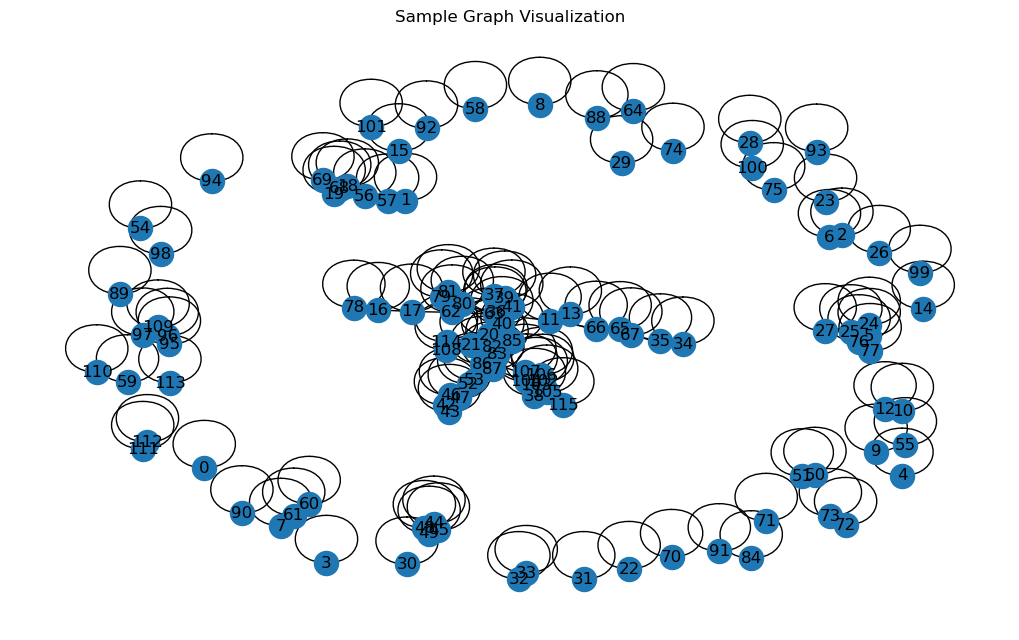

In [28]:
# Testing the class Raw_to_Graph with one example and saving it
threshold = 0.7
weight = False
age = False
sex = False
matrixprofile = False
method = 'pearson'

root = f'Raw_to_graph/ADNI_T_{threshold}_M_{method}_W{weight}_A{age}_S{sex}_MP{matrixprofile}'
dataset = Raw_to_Graph(root=root, threshold=threshold, method=method, weight=weight)
dataset_features_and_stats(dataset)



In [10]:
# Testing the class Raw_to_Graph with different thresholds, weights and methods and saving it
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
weights = [True, False]
age = False
sex = False
matrixprofile = False
# methods = ['pearson', 'spearman', 'kendall', 'partial']
methods = ['pearson']

for weight in weights:
    for method in methods:
        for threshold in thresholds:
            root = f'Raw_to_graph/ADNI_T_{threshold}_M_{method}_W{weight}_A{age}_S{sex}_MP{matrixprofile}'
            dataset = Raw_to_Graph(root=root, threshold=threshold, method=method, weight=weight)
            dataset_features_and_stats(dataset)


Dataset: Raw_to_Graph(197):
Number of graphs: 197
Weighted: True
Threshold: 0.1
Correlation Method: pearson
Number of features: 5
Number of classes: 4

Data(edge_index=[2, 9816], weight=[9816], x=[116, 5], y='0', num_nodes=116)
Number of nodes: 116
Number of edges: 9816
Average node degree: 84.62
Has isolated nodes: False
Has self-loops: True
Is undirected: True

Dataset: Raw_to_Graph(197):
Number of graphs: 197
Weighted: True
Threshold: 0.2
Correlation Method: pearson
Number of features: 5
Number of classes: 4

Data(edge_index=[2, 6686], weight=[6686], x=[116, 5], y='0', num_nodes=116)
Number of nodes: 116
Number of edges: 6686
Average node degree: 57.64
Has isolated nodes: False
Has self-loops: True
Is undirected: True

Dataset: Raw_to_Graph(197):
Number of graphs: 197
Weighted: True
Threshold: 0.3
Correlation Method: pearson
Number of features: 5
Number of classes: 4

Data(edge_index=[2, 4054], weight=[4054], x=[116, 5], y='0', num_nodes=116)
Number of nodes: 116
Number of edges: 4